In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
import math
import os
import glob

# import matplotlib
# matplotlib.use('module://ipympl.backend_nbagg')
# %matplotlib widget

# import PyQt5
# import os
# os.environ["QT_API"] = "pyqt5"

In [79]:
sys.path.append("/Users/pnr5sh/Documents/phd/mmmp/")
import sidchaini.sidhelpers as sidhelpers

In [80]:
#reading in meta data from sid's dir
header = ['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC', 'Obj. Type',
          'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)', 'From', 'Telescope',
          'Instrument', 'Observer/s', 'Reducer/s', 'Source group', 'Public', 'Associated groups',
          'End prop. period', 'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
          'Extinction-Corrected', 'WL Medium','WL Units', 'Flux Unit Coefficient', 'Spec. units',
          'Flux Calibrated By', 'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
          'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib', 'Publish', 'Remarks',
          'Created by', 'Creation date']
all_spec_meta = pd.read_csv('../sidchaini/1. download ALL wise data/wiserep_spectra_combined.csv', header='infer')# names=header, delimiter=', ', skiprows=1)
all_spec_meta.columns

Index(['wise_objid', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [81]:
# filters for specific types
multi_types = (all_spec_meta['Obj. Type']=='SN IIb')|(all_spec_meta['Obj. Type']=='SN Ib')|(all_spec_meta['Obj. Type']=='SN Ic')|(all_spec_meta['Obj. Type']=='SLSN-I')|(all_spec_meta['Obj. Type']=='SLSN-II')|(all_spec_meta['Obj. Type']=='SN IIn')

#filters for ZTF/P60 data
p60 = (all_spec_meta['Telescope']=='P60')
sedm = (all_spec_meta['Instrument']=='SEDM')

#creating filters based on types for big DF
iib = (all_spec_meta['Obj. Type']=='SN IIb')
ib = (all_spec_meta['Obj. Type']=='SN Ib')
ic = (all_spec_meta['Obj. Type']=='SN Ic')
slsni = (all_spec_meta['Obj. Type']=='SLSN-I')
slsnii = (all_spec_meta['Obj. Type']=='SLSN-II')
iin = (all_spec_meta['Obj. Type']=='SN IIn')

In [89]:
types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SLSN-I']
types_flags = [iib, ib, ic, slsni]

for i,types in enumerate(types_flags):
    objs = all_spec_meta.loc[types&p60&sedm,'IAU name'].unique().tolist() #list of IIb names

    ras, decs, jd_starts, jd_ends, obj_name = [],[],[],[],[]
    for j in range(len(objs)):
        ra = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'Obj. RA'].iloc[0]
        dec = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'Obj. DEC'].iloc[0]
        jd = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'JD'].iloc[0] #JD of spectra taken for individ obj
        name = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'IAU name'].iloc[0]
        ras.append(ra)
        decs.append(dec)
        jd_starts.append(jd-50)
        jd_ends.append(jd+150)
        obj_name.append(name)
    
    typs = [types_str[i]]*len(ras)
    d = {'ra':ras, 'dec':decs, 'jd_start':jd_starts, 'jd_end':jd_ends, 'obj_name':obj_name, 'type':typs}
    ztf_info = pd.DataFrame(d)
    ztf_info.to_csv(f"./ztf_fp_info_for_{types_str[i]}.csv", index=False)

In [90]:
# creating df of only objects meeting our target types, from ZTF 
mp_spec_df = all_spec_meta.loc[multi_types&p60&sedm]

In [91]:
types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SLSN-I']
types_flags = [iib, ib, ic, slsni]

for i,types in enumerate(types_flags):
    objs = all_spec_meta.loc[types&p60&sedm,'IAU name'].unique().tolist() #list of IIb names

    ras, decs, jd_starts, jd_ends, obj_name = [],[],[],[],[]
    for j in range(len(objs)):
        ra = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'Obj. RA'].iloc[0]

In [92]:
# #read in ztf lc data into DF and also header info
# #isolate ra/dec from header and cross-match to mp_spec_df values to find corresponding SN
# #rename file 

# datadir = './ztf_fp_data/ib/'

# filenames = [datadir+f for f in os.listdir(datadir)]

# ra_str = '# Requested input R.A. = '
# dec_str = '# Requested input Dec. = '
# for i,filename in enumerate(filenames):
#     ra = float()
#     dec = float()
#     with open(filename, 'r') as file:
#         header = [next(file) for x in range(54)]
#         for line in header:
#             if line.startswith(ra_str):
#                 ra = float(line[len(ra_str):-8])
#             if line.startswith(dec_str):
#                 dec = float(line[len(dec_str):-8])
#     idx = [mp_spec_df['Obj. RA'].sub(ra).abs().idxmin()] # list of index matching the ra
#     if len(idx)>0:
#         name = mp_spec_df.loc[idx[0],'IAU name'][3:]
#         savefile = datadir+name+'_fp_lc.txt'
#         #rename the file w/ the IAU name
#         os.system(f"cp {filename} {savefile}")
#     else:
#         print(f"Unable to find closest match to RA={ra}")

In [93]:
# #check if the matched file names match the object names

# li = mp_spec_df.loc[mp_spec_df['Obj. Type']=='SN Ib', 'IAU name'].sort_values().unique()
# for l in li:
#     print(l)

In [115]:
datadir = './ztf_fp_data/iib/'
files = sorted(glob.glob(datadir+'*_fp_lc.txt'))
ztf_info_df = pd.read_csv('ztf_fp_info_for_SN IIb.csv')

sn_names, lc_dfs = [],[]
for file in files:
    sn_name = file[18:-10] #NOTE: FIRST INDEX CHANGES W/ DATADIR NAME LENGTH
    sn_names.append(sn_name)
    
    cols = ['index', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix',
            'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
            'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc',
            'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr',
            'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
    df = pd.read_csv(file, names=cols, header=None, sep=" ", skiprows=54)
    df = df.set_index(df['index'])  # manually setting indeces
    df = df.drop(columns=['index']) # drop duplicated index 
    df = df[(df['infobitssci'] < 33554432) & (df['scisigpix'] <= 25) & (df['sciinpseeing'] <= 4) & (df['forcediffimflux']!=-99999.0)].reset_index(drop=True) #clean according to docs

    # cut df down to -50 days to +365 days centered on date of first spectra
    # time window included in ztf_fp_info*csv files for each obj type
    obj = ztf_info_df.loc[ztf_info_df['obj_name'].str[3:]==sn_name]
    start_jd = obj['jd_start'].iloc[0]
    end_jd = obj['jd_end'].iloc[0]
    df_cut = df.loc[(df['jd']<end_jd)&(df['jd']>start_jd)] #only selecting points that fall within specified time window
    df_cut = df_cut.reset_index(drop=True)
    df_cut = df_cut.infer_objects() #infering dtype of columns
    
    mag = df_cut['zpdiff'] - 2.5 * np.log10(df_cut['forcediffimflux'])
    sigma_mag = 1.0857 * df_cut['forcediffimfluxunc']/df_cut['forcediffimflux']
    df_cut['mag'] = mag
    df_cut['e_mag'] = sigma_mag
    df_cut = df_cut.loc[(df_cut['forcediffimflux']>0) & (df_cut['e_mag']<2)].reset_index(drop=True) #only selecting points w/ non-nan mags and errorbars less than 2 mags

    lc_dfs.append(df_cut)

/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/User

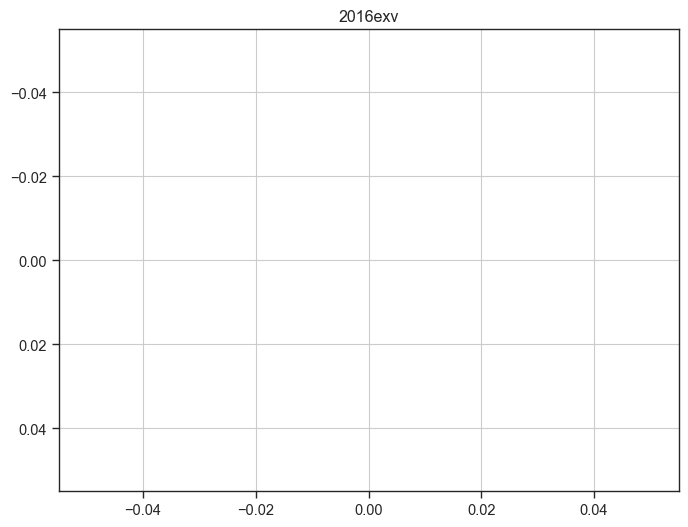

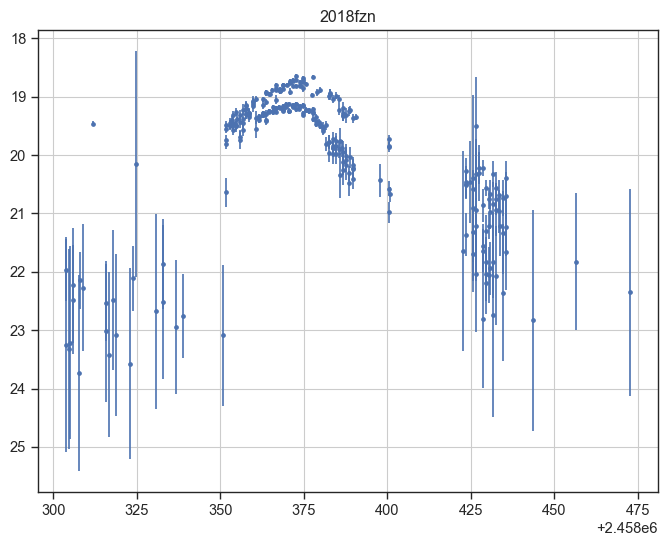

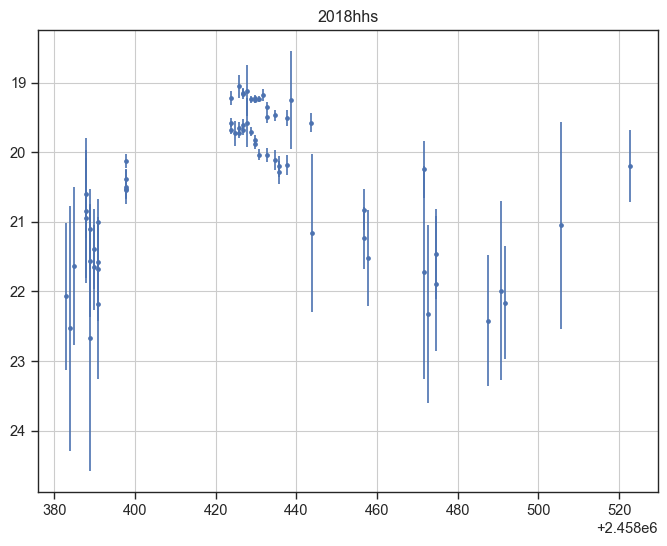

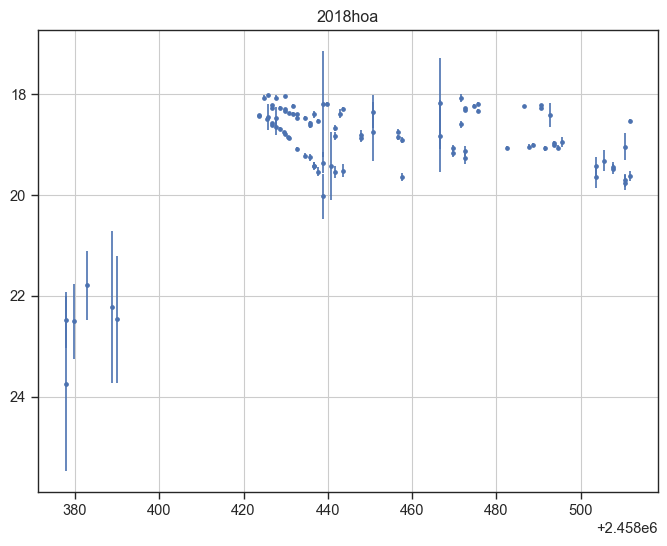

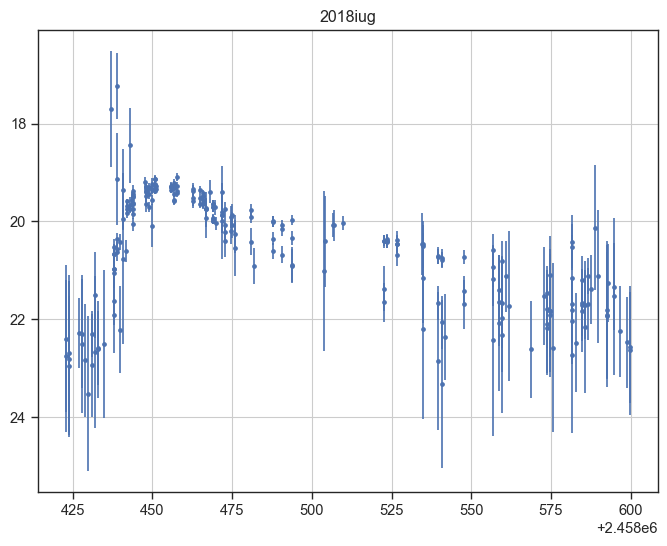

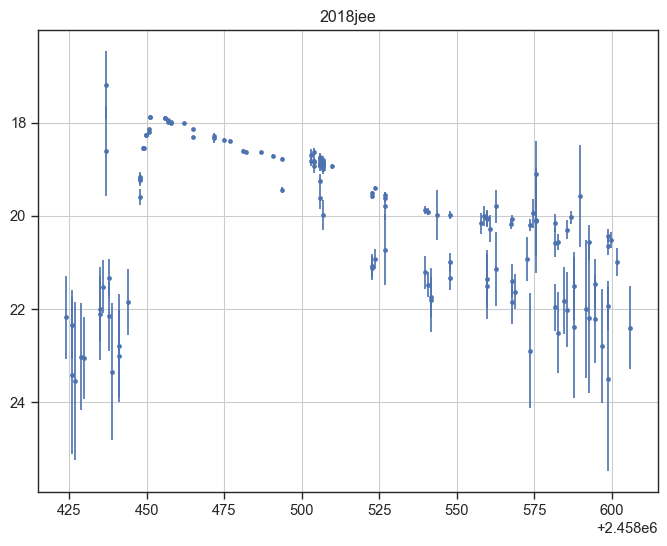

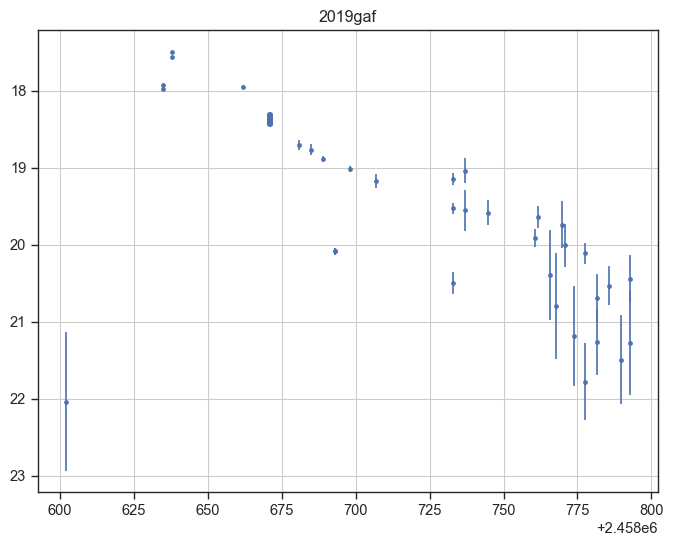

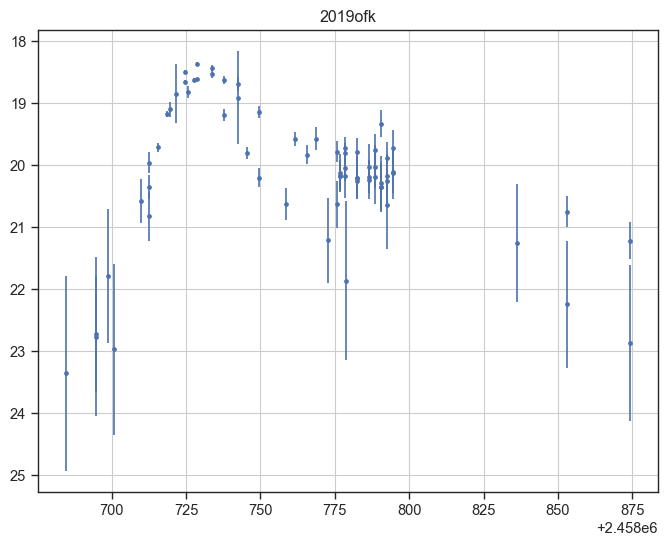

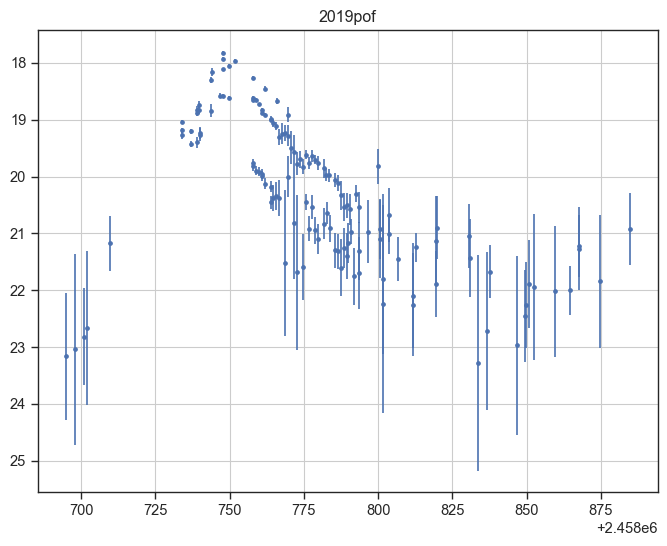

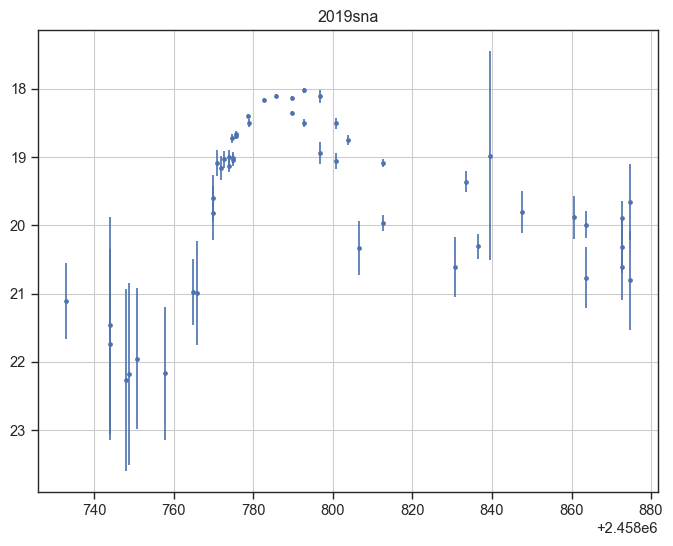

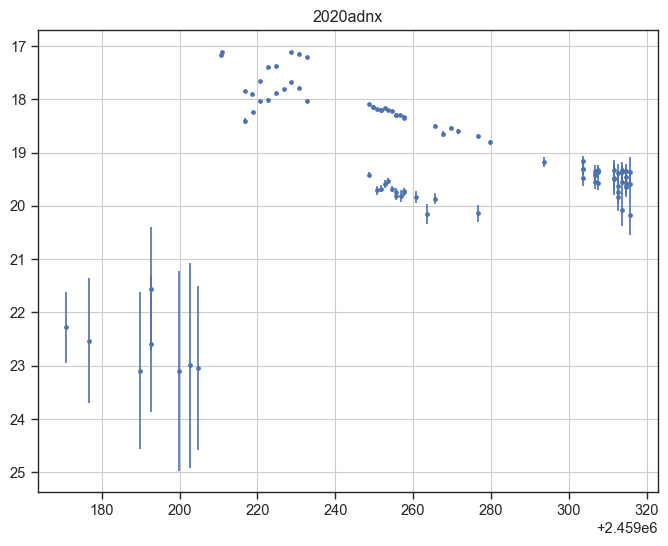

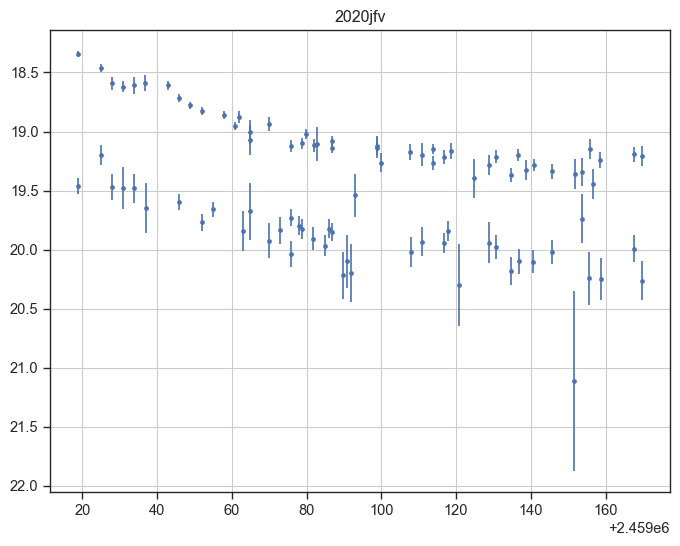

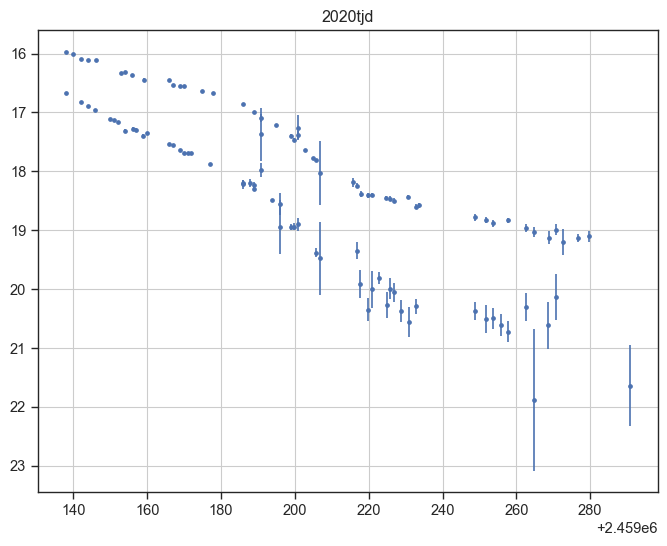

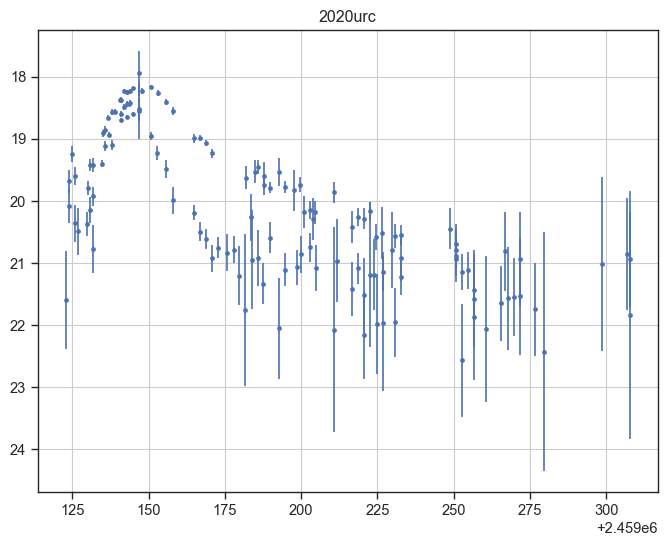

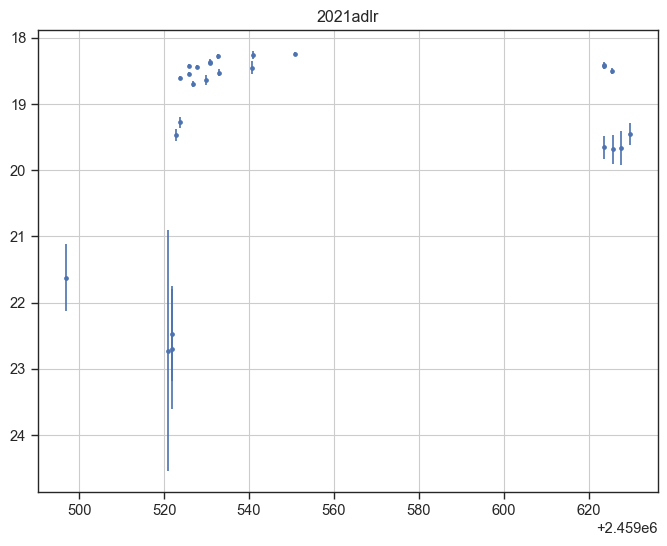

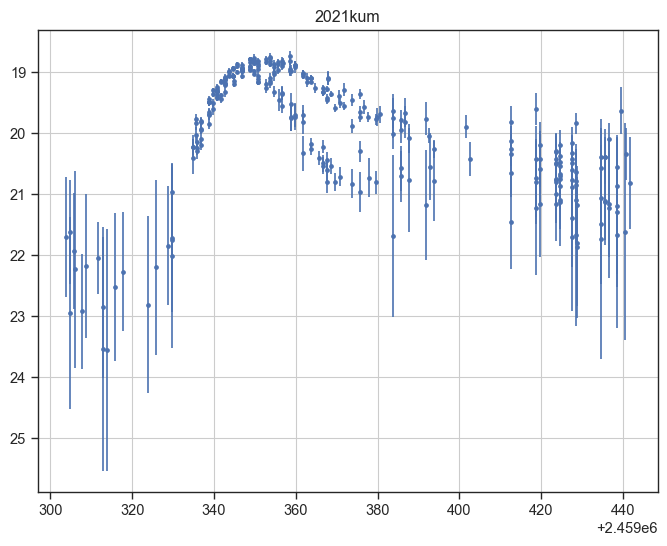

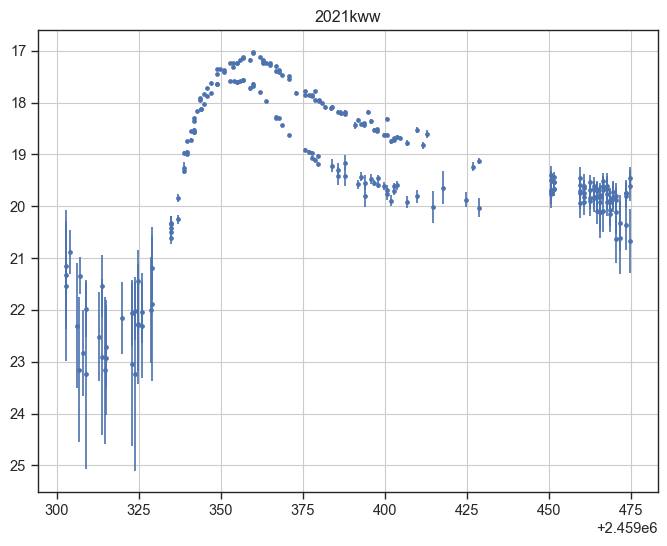

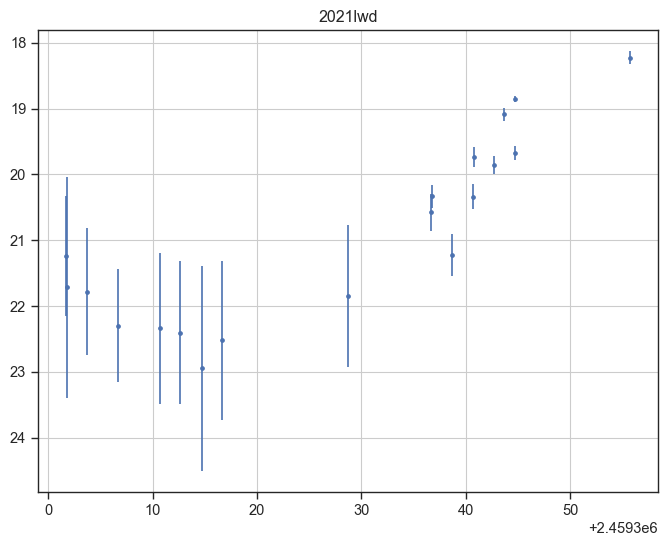

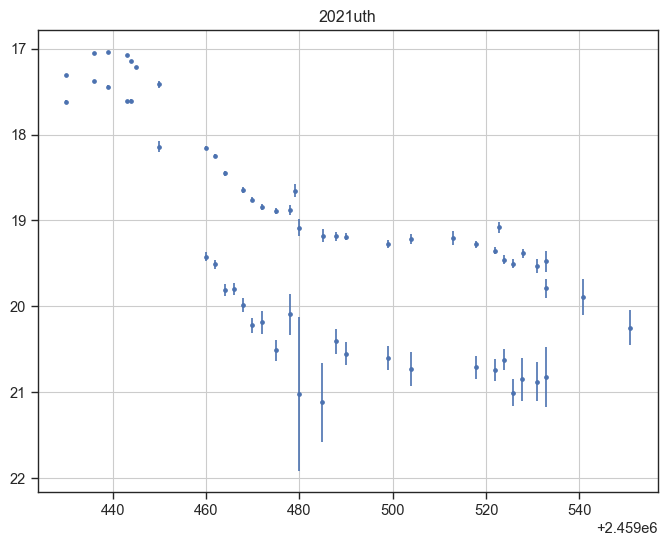

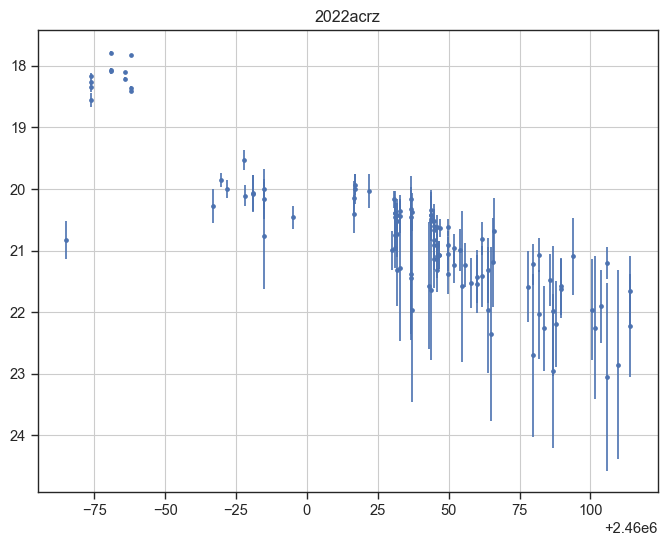

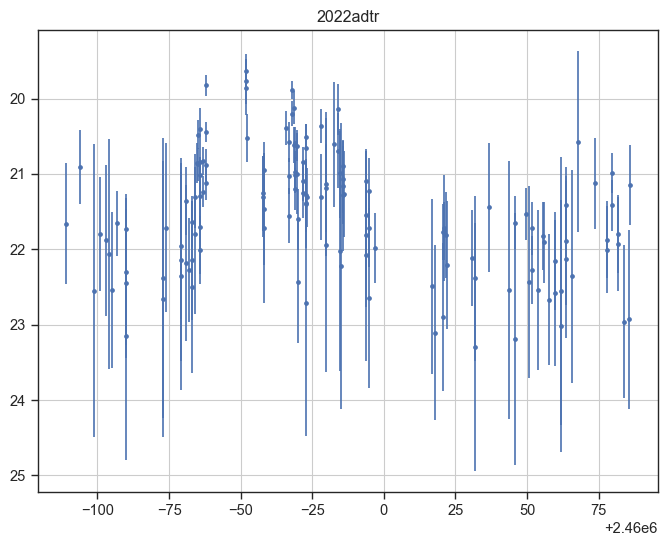

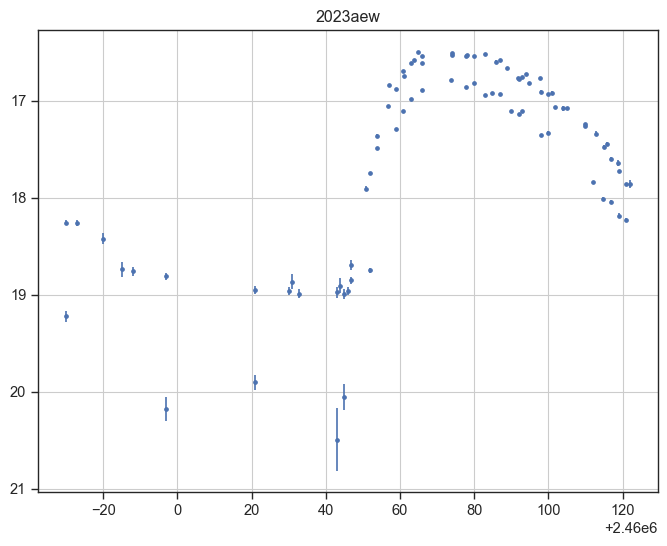

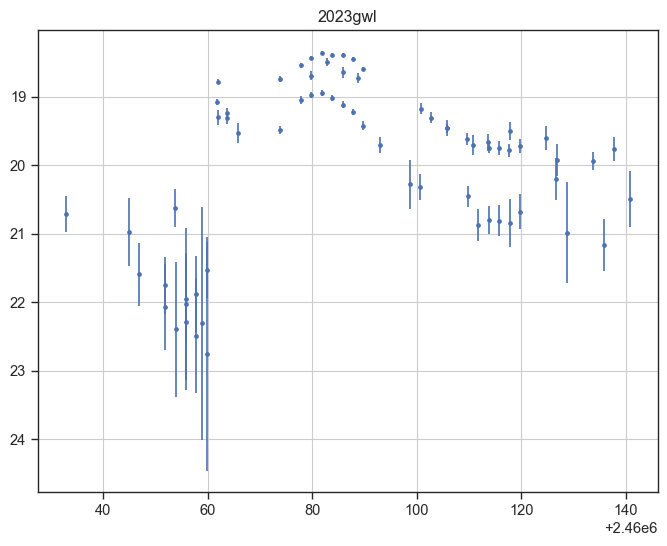

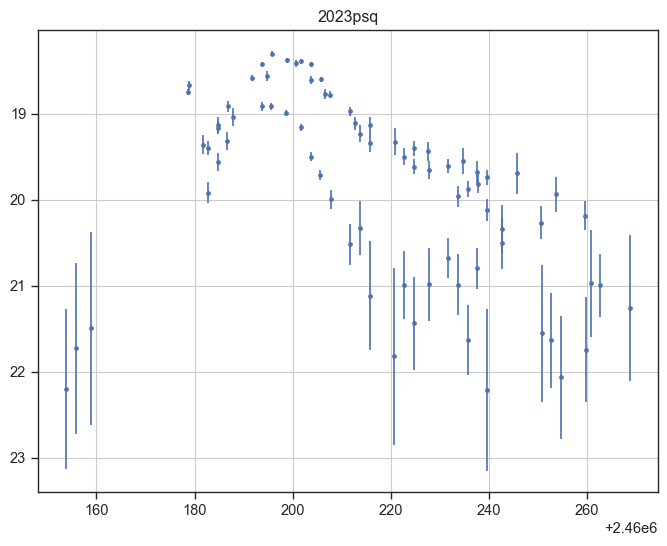

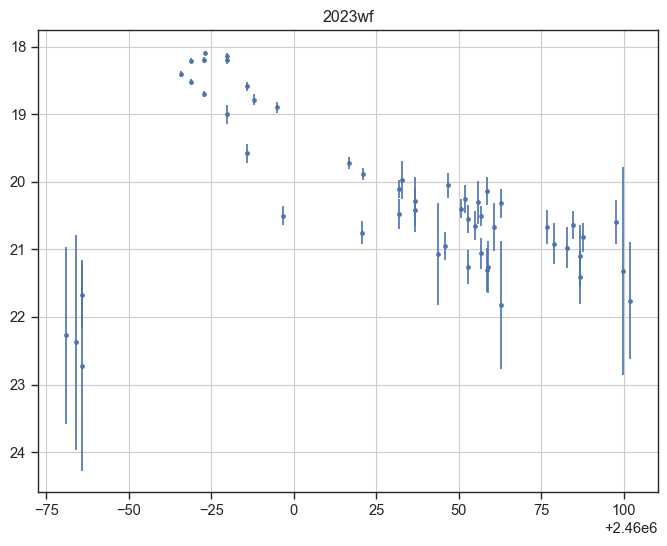

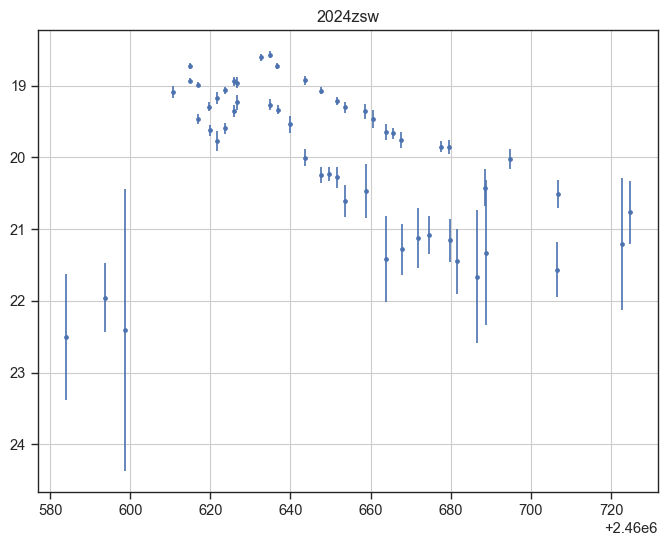

In [117]:
%matplotlib inline
for i in range(len(lc_dfs)):
    plt.figure(figsize=(8,6))
    plt.errorbar(lc_dfs[i]['jd'], lc_dfs[i]['mag'], yerr=lc_dfs[i]['e_mag'],ls='', marker='.')
    plt.gca().invert_yaxis()
    plt.title(sn_names[i])
    plt.show()